In [1]:
import tensorflow as tf
import tensorflow_probability as tfp
import numpy as np
import matplotlib.pyplot as plt
tfd = tfp.distributions

In [2]:
negloglik = lambda y, p_y: -p_y.log_prob(y)

In [3]:
#@title Synthesize dataset.
w0 = 0.125
b0 = 5.
x_range = [-20, 60]

def load_dataset(n=150, n_tst=150):
  np.random.seed(43)
  def s(x):
    g = (x - x_range[0]) / (x_range[1] - x_range[0])
    return 3 * (0.25 + g**2.)
  x = (x_range[1] - x_range[0]) * np.random.rand(n) + x_range[0]
  eps = np.random.randn(n) * s(x)
  y = (w0 * x * (1. + np.sin(x)) + b0) + eps
  x = x[..., np.newaxis]
  x_tst = np.linspace(*x_range, num=n_tst).astype(np.float32)
  x_tst = x_tst[..., np.newaxis]
  return y, x, x_tst

y, x, x_tst = load_dataset()

In [4]:
model = tf.keras.Sequential([
    tf.keras.layers.Dense(1), 
    tfp.layers.DistributionLambda(lambda t: tfd.Normal(loc=t, scale=1)),
])

In [5]:
model.compile(optimizer=tf.optimizers.Adam(learning_rate=0.05), loss=negloglik)
model.fit(x,y, epochs=500, verbose=False)

In [6]:
yhat = model(x_tst)

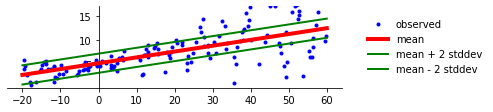

In [7]:
plt.figure(figsize=[6, 1.5])  # inches
plt.plot(x, y, 'b.', label='observed');

m = yhat.mean()
s = yhat.stddev()

plt.plot(x_tst, m, 'r', linewidth=4, label='mean');
plt.plot(x_tst, m + 2 * s, 'g', linewidth=2, label=r'mean + 2 stddev');
plt.plot(x_tst, m - 2 * s, 'g', linewidth=2, label=r'mean - 2 stddev');

plt.ylim(-0.,17);
plt.yticks(np.linspace(0, 15, 4)[1:]);
plt.xticks(np.linspace(*x_range, num=9));

ax=plt.gca();
ax.xaxis.set_ticks_position('bottom')
ax.yaxis.set_ticks_position('left')
ax.spines['left'].set_position(('data', 0))
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
#ax.spines['left'].set_smart_bounds(True)
#ax.spines['bottom'].set_smart_bounds(True)
plt.legend(loc='center left', fancybox=True, framealpha=0., bbox_to_anchor=(1.05, 0.5))

In [9]:
model = tf.keras.Sequential([
    tf.keras.layers.Dense(1+1),
    tfp.layers.DistributionLambda(
        lambda t: tfd.Normal(loc=t[..., :1], scale=1e-3 + tf.math.softplus(0.05 * t[..., 1:]))),
        ])

model.compile(optimizer=tf.optimizers.Adam(learning_rate=0.05), loss=negloglik)
model.fit(x, y, epochs=500, verbose=False)

# Make predictions.
yhat = model(x_tst)

In [15]:
print(f'test set length {len(x_tst)}')
print(yhat.mean()[0])
print(yhat.stddev()[0])
print(yhat.variance()[0])

test set length 150
tf.Tensor([2.6873317], shape=(1,), dtype=float32)
tf.Tensor([0.40741378], shape=(1,), dtype=float32)
tf.Tensor([0.16598599], shape=(1,), dtype=float32)


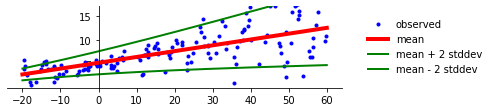

In [45]:
plt.figure(figsize=[6, 1.5])  # inches
plt.plot(x, y, 'b.', label='observed');

m = yhat.mean()
s = yhat.stddev()

plt.plot(x_tst, m, 'r', linewidth=4, label='mean');
plt.plot(x_tst, m + 2 * s, 'g', linewidth=2, label=r'mean + 2 stddev');
plt.plot(x_tst, m - 2 * s, 'g', linewidth=2, label=r'mean - 2 stddev');

plt.ylim(-0.,17);
plt.yticks(np.linspace(0, 15, 4)[1:]);
plt.xticks(np.linspace(*x_range, num=9));

ax=plt.gca();
ax.xaxis.set_ticks_position('bottom')
ax.yaxis.set_ticks_position('left')
ax.spines['left'].set_position(('data', 0))
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
#ax.spines['left'].set_smart_bounds(True)
#ax.spines['bottom'].set_smart_bounds(True)
plt.legend(loc='center left', fancybox=True, framealpha=0., bbox_to_anchor=(1.05, 0.5))

In [46]:
# Specify the surrogate posterior over `keras.layers.Dense` `kernel` and `bias`.
def posterior_mean_field(kernel_size, bias_size=0, dtype=None):
  n = kernel_size + bias_size
  c = np.log(np.expm1(1.))
  return tf.keras.Sequential([
      tfp.layers.VariableLayer(2 * n, dtype=dtype),
      tfp.layers.DistributionLambda(lambda t: tfd.Independent(
          tfd.Normal(loc=t[..., :n],
                     scale=1e-5 + tf.nn.softplus(c + t[..., n:])),
          reinterpreted_batch_ndims=1)),
  ])

In [47]:
# Specify the prior over `keras.layers.Dense` `kernel` and `bias`.
def prior_trainable(kernel_size, bias_size=0, dtype=None):
  n = kernel_size + bias_size
  return tf.keras.Sequential([
      tfp.layers.VariableLayer(n, dtype=dtype),
      tfp.layers.DistributionLambda(lambda t: tfd.Independent(
          tfd.Normal(loc=t, scale=1),
          reinterpreted_batch_ndims=1)),
  ])

In [50]:
model = tf.keras.Sequential([
    tfp.layers.DenseVariational(1, posterior_mean_field, prior_trainable),
    tfp.layers.DistributionLambda(lambda t: tfd.Normal(loc=t, scale=1)),
])

In [51]:
model.compile(optimizer=tf.optimizers.Adam(learning_rate=0.05), loss=negloglik)
model.fit(x, y, epochs=500, verbose=False)

In [52]:
# Make predictions.
yhats = [model(x_tst) for i in range(100)]

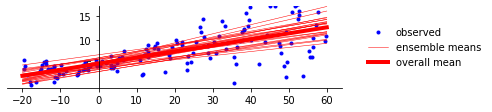

In [54]:
plt.figure(figsize=[6, 1.5])  # inches
plt.clf();
plt.plot(x, y, 'b.', label='observed');

yhats = [model(x_tst) for _ in range(100)]
avgm = np.zeros_like(x_tst[..., 0])
for i, yhat in enumerate(yhats):
  m = np.squeeze(yhat.mean())
  s = np.squeeze(yhat.stddev())
  if i < 25:
    plt.plot(x_tst, m, 'r', label='ensemble means' if i == 0 else None, linewidth=0.5)
  avgm += m
plt.plot(x_tst, avgm/len(yhats), 'r', label='overall mean', linewidth=4)

plt.ylim(-0.,17);
plt.yticks(np.linspace(0, 15, 4)[1:]);
plt.xticks(np.linspace(*x_range, num=9));

ax=plt.gca();
ax.xaxis.set_ticks_position('bottom')
ax.yaxis.set_ticks_position('left')
ax.spines['left'].set_position(('data', 0))
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
#ax.spines['left'].set_smart_bounds(True)
#ax.spines['bottom'].set_smart_bounds(True)
plt.legend(loc='center left', fancybox=True, framealpha=0., bbox_to_anchor=(1.05, 0.5))

plt.savefig('/tmp/fig3.png', bbox_inches='tight', dpi=300)

In [55]:
model = tf.keras.Sequential([
    tfp.layers.DenseVariational(1+1,  posterior_mean_field, prior_trainable),
    tfp.layers.DistributionLambda(lambda t: tfd.Normal(loc=t[..., :1], scale=1e-3 + tf.math.softplus(0.01*t[..., 1:]))),
])

In [56]:
# Do inference.
model.compile(optimizer=tf.optimizers.Adam(learning_rate=0.05), loss=negloglik)
model.fit(x, y, epochs=500, verbose=False);

# Make predictions.
yhats = [model(x_tst) for _ in range(100)]

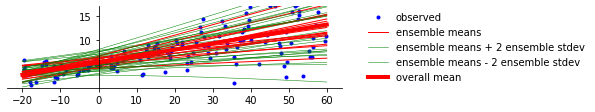

In [59]:
#@title Figure 4: Both Aleatoric & Epistemic Uncertainty
plt.figure(figsize=[6, 1.5])  # inches
plt.plot(x, y, 'b.', label='observed');

yhats = [model(x_tst) for _ in range(100)]
avgm = np.zeros_like(x_tst[..., 0])
for i, yhat in enumerate(yhats):
  m = np.squeeze(yhat.mean())
  s = np.squeeze(yhat.stddev())
  if i < 15:
    plt.plot(x_tst, m, 'r', label='ensemble means' if i == 0 else None, linewidth=1.)
    plt.plot(x_tst, m + 2 * s, 'g', linewidth=0.5, label='ensemble means + 2 ensemble stdev' if i == 0 else None);
    plt.plot(x_tst, m - 2 * s, 'g', linewidth=0.5, label='ensemble means - 2 ensemble stdev' if i == 0 else None);
  avgm += m
plt.plot(x_tst, avgm/len(yhats), 'r', label='overall mean', linewidth=4)

plt.ylim(-0.,17);
plt.yticks(np.linspace(0, 15, 4)[1:]);
plt.xticks(np.linspace(*x_range, num=9));

ax=plt.gca();
ax.xaxis.set_ticks_position('bottom')
ax.yaxis.set_ticks_position('left')
ax.spines['left'].set_position(('data', 0))
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
#ax.spines['left'].set_smart_bounds(True)
#ax.spines['bottom'].set_smart_bounds(True)
plt.legend(loc='center left', fancybox=True, framealpha=0., bbox_to_anchor=(1.05, 0.5))

plt.savefig('/tmp/fig4.png', bbox_inches='tight', dpi=300)

In [60]:
class RBFKernelFn(tf.keras.layers.Layer):
  def __init__(self, **kwargs):
    super(RBFKernelFn, self).__init__(**kwargs)
    dtype = kwargs.get('dtype', None)

    self._amplitude = self.add_variable(
            initializer=tf.constant_initializer(0),
            dtype=dtype,
            name='amplitude')
    
    self._length_scale = self.add_variable(
            initializer=tf.constant_initializer(0),
            dtype=dtype,
            name='length_scale')

  def call(self, x):
    # Never called -- this is just a layer so it can hold variables
    # in a way Keras understands.
    return x

  @property
  def kernel(self):
    return tfp.math.psd_kernels.ExponentiatedQuadratic(
      amplitude=tf.nn.softplus(0.1 * self._amplitude),
      length_scale=tf.nn.softplus(5. * self._length_scale)
    )

In [61]:
num_inducing_points = 40
model = tf.keras.Sequential([
    tf.keras.layers.InputLayer(input_shape=[1], dtype=x.dtype),
    tf.keras.layers.Dense(1, kernel_initializer='ones', use_bias=False),
    tfp.layers.VariationalGaussianProcess(
    num_inducing_points=num_inducing_points,
        kernel_provider=RBFKernelFn(dtype=x.dtype),
        event_shape=[1],
        inducing_index_points_initializer=tf.constant_initializer(
            np.linspace(*x_range, num=num_inducing_points, dtype=x.dtype)[..., np.newaxis]),
        unconstrained_observation_noise_variance_initializer=(tf.constant_initializer(np.log(np.expm1(1.)).astype(x.dtype)))
    )
])

Instructions for updating:
Please use `layer.add_weight` method instead.

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

Instructions for updating:
Do not pass `graph_parents`.  They will  no longer be used.


/home/torresrl/anaconda3/lib/python3.7/site-packages/tensorflow_probability/python/distributions/gaussian_process.py:305: UserWarning: Unable to detect statically whether the number of index_points is 1. As a result, defaulting to treating the marginal GP at `index_points` as a multivariate Gaussian. This makes some methods, like `cdf` unavailable.
  'Unable to detect statically whether the number of index_points is '


In [62]:
# Do inference.
batch_size = 32
loss = lambda y, rv_y: rv_y.variational_loss(
    y, kl_weight=np.array(batch_size, x.dtype) / x.shape[0])
model.compile(optimizer=tf.optimizers.Adam(learning_rate=0.01), loss=loss)
model.fit(x, y, batch_size=batch_size, epochs=1000, verbose=False)

# Make predictions.
yhats = [model(x_tst) for _ in range(100)]

/home/torresrl/anaconda3/lib/python3.7/site-packages/tensorflow_probability/python/distributions/gaussian_process.py:305: UserWarning: Unable to detect statically whether the number of index_points is 1. As a result, defaulting to treating the marginal GP at `index_points` as a multivariate Gaussian. This makes some methods, like `cdf` unavailable.
  'Unable to detect statically whether the number of index_points is '


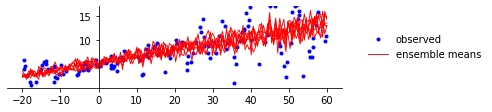

In [63]:
y, x, _ = load_dataset()

plt.figure(figsize=[6, 1.5])  # inches
plt.plot(x, y, 'b.', label='observed');

num_samples = 7
for i in range(num_samples):
  sample_ = yhat.sample().numpy()
  plt.plot(x_tst,
           sample_[..., 0].T,
           'r',
           linewidth=0.9,
           label='ensemble means' if i == 0 else None);

plt.ylim(-0.,17);
plt.yticks(np.linspace(0, 15, 4)[1:]);
plt.xticks(np.linspace(*x_range, num=9));

ax=plt.gca();
ax.xaxis.set_ticks_position('bottom')
ax.yaxis.set_ticks_position('left')
ax.spines['left'].set_position(('data', 0))
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
#ax.spines['left'].set_smart_bounds(True)
#ax.spines['bottom'].set_smart_bounds(True)
plt.legend(loc='center left', fancybox=True, framealpha=0., bbox_to_anchor=(1.05, 0.5))

plt.savefig('/tmp/fig5.png', bbox_inches='tight', dpi=300)